In [5]:
# General
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# For Vectorizing tokens and LDA
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# For PCA estimation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# For NLP pre-processing text 
from nltk.corpus import stopwords 
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize 

In [6]:
syns_raw = pd.read_csv("../raw_data/wine_synonyms_csv.csv", index_col=0)
syns_raw.head(3)

,NAME_ORIGINAL,NAME_SYNONYMS,NAME_DIRTY,NAME_ALL,TYPE,Blend
ID_original_Order,,,,,,
w003,Abouriou,NaN,NaN,Abouriou,Red,single_var
w004,Agiorgitiko,St. George,NaN,"Agiorgitiko, St. George",Red,single_var
w005,Aglianico,NaN,NaN,Aglianico,Red,single_var


In [111]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

### Loading the dataset - Clean & with unified grape-variety synonyms

In [72]:
def clean_rawdata():
    '''Once called, reads the raw data and convert it in a Pandas Dataframe.
        Carries out the cleaning tasks and returns a clean Dataframe, also saves
        a csv file locally'''


    #Clean duplicates and deals with unmatched grape varieties
    df = pd.read_csv("../raw_data/wine_data_csv.csv", index_col=0)
    df.drop_duplicates(inplace=True)
    columns_to_drop=['designation','region_2','taster_name','taster_twitter_handle','region_1']
    df.drop(columns=columns_to_drop,inplace=True)
    #df.dropna(inplace=True)
    df.drop(df[df['type']=='delete'].index,inplace=True)
    # df.to_csv("./raw_data/preprocessed_data.csv", index=False) #backup file moved to after resolve_synonyms()
    return df

def resolve_synonyms(df:pd.DataFrame)->pd.DataFrame:
    '''Reads the original data and implement standardised names for grape
    varieties. The user does not know this happens in the background,
    recommendations are still provided in the original variety.'''
    # Loading wine synonyms input data from file created with unique grape for one or several wines
    syns_raw = pd.read_csv("../raw_data/wine_synonyms_csv.csv", index_col=0)
    # Extracting the single column from the synonyms files that has all synonyns for each row
    all_grape_names = syns_raw.NAME_ALL.str.split(', ')
    # The synonyms file has multiple rows (synonyms) that hasn't been unified (synonymised) properly.
    # Here a table of synonyms is created to consolidate all synonyms.
    syns = {}     # for each item: key will be main synonym, values will include all synonyms including the main one (used for key)
    for row in all_grape_names:
        flat_dict = [num for elem in list(syns.values()) for num in elem]
        # checking if synonyms in each row are already present is the dictionary being created
        # if not, it creates a key and values
        if any(grape in flat_dict for grape in row) == False:
            syns[row[0]] = row
        # if yes, adds the new synonyns that don't exist yet in the list
        else:
            res = next((sub for sub in syns if any(grape in syns[sub] for grape in row) == True), None)
            syns[res].extend([item for item in row if item not in syns[res]])
    del flat_dict
    # Using the unified synonym table, it populates the column for grape vaiety in the main data table
    # with the main synonyms for each grape variety
    #df['variety_adj'] = df['variety'].apply(lambda grape: next((key for key, value in syns.items() if grape in value), None))
    #df.drop(columns=['variety'], inplace=True)
    def match_grape(grape):
        for key, value in syns.items():
            if grape in value:
                return key
    df['variety_adj'] = df['variety'].apply(match_grape)

    # ESTA 2 SGTEs LINEAS LA PUSE YO
    
    display(print(df))
    df.reset_index(inplace=True)
    df.drop(columns=['country', 'points', 'price', 'title', 'variety', 'winery', ], inplace=True)
    df = df[['ID','description', 'variety_adj', 'type', 'province', 'region']]

    
    df.to_csv("../raw_data/preprocessed_data.csv", index=False)

    return df

In [73]:
df = clean_rawdata()

In [74]:
df = resolve_synonyms(df)

         country                                        description  points  \
ID                                                                            
0          Italy  Aromas include tropical fruit, broom, brimston...      87   
1       Portugal  This is ripe and fruity, a wine that is smooth...      87   
2             US  Tart and snappy, the flavors of lime flesh and...      87   
3             US  Pineapple rind, lemon pith and orange blossom ...      87   
4             US  Much like the regular bottling from 2012, this...      87   
...          ...                                                ...     ...   
129966   Germany  Notes of honeysuckle and cantaloupe sweeten th...      90   
129967        US  Citation is given as much as a decade of bottl...      90   
129968    France  Well-drained gravel soil gives this wine its c...      90   
129969    France  A dry style of Pinot Gris, this is crisp with ...      90   
129970    France  Big, rich and off-dry, this is pow

None

In [90]:
df=pd.read_csv("../raw_data/preprocessed_data.csv", index_col=0)
df.reset_index(inplace=True)
df

,country,description,points,price,province,title,winery,type,region,variety_adj
0,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Quinta dos Avidagos,red,Douro,Portuguese Red
1,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Rainstorm,white,Willamette Valley,Pinot Gris
2,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,St. Julian,white,Lake Michigan Shore,Riesling
3,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Sweet Cheeks,red,Willamette Valley,Pinot Noir
4,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tandem,red,Navarra,Tempranillo-Merlot
...,...,...,...,...,...,...,...,...,...,...
111531,Germany,Notes of honeysuckle and cantaloupe sweeten th...,90,28.0,Mosel,Dr. H. Thanisch (Erben MÃ¼ller-Burggraef) 2013...,Dr. H. Thanisch (Erben MÃ¼ller-Burggraef),white,Mosel,Riesling
111532,US,Citation is given as much as a decade of bottl...,90,75.0,Oregon,Citation 2004 Pinot Noir (Oregon),Citation,red,Oregon,Pinot Noir
111533,France,Well-drained gravel soil gives this wine its c...,90,30.0,Alsace,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Domaine Gresser,white,Alsace,Gewurztraminer
111534,France,"A dry style of Pinot Gris, this is crisp with ...",90,32.0,Alsace,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Domaine Marcel Deiss,white,Alsace,Pinot Gris


#### All code above was done just to generate the data to really start working in NLP (below)
#### So probably not critical because all above has been already integrated in the py files.
#### All below is new an easential for the NLP token generation

### Processing wine description column:  Tokenizing Lemmatizing, etc

In [116]:
# This takes about 40 secs in Jaime's laptop
#from nltk.corpus import stopwords 
#import string
#from nltk.stem.wordnet import WordNetLemmatizer
#from nltk import word_tokenize 

def clean (text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ') # Remove Punctuation
    text = text.strip() ## remove whitespaces
    lowercased = text.lower() # Lower Case
    tokenized = word_tokenize(lowercased) # Tokenize
    words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
    stop_words = set(stopwords.words('english')) # Make stopword list
    without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words
    lemma=WordNetLemmatizer() # Initiate Lemmatizer
    lemmatized = [lemma.lemmatize(word) for word in without_stopwords] # Lemmatize
    cleaned = ' '.join(lemmatized) # Join back to a string
    return cleaned

# Apply to all texts
df['description_clean'] = df.description.apply(clean)

df.head(3)

,index,country,description,points,price,province,title,winery,type,region,variety_adj,description_clean
0,0,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Quinta dos Avidagos,red,Douro,Portuguese Red,ripe fruity wine smooth still structured firm ...
1,1,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Rainstorm,white,Willamette Valley,Pinot Gris,tart snappy flavor lime flesh rind dominate gr...
2,2,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,St. Julian,white,Lake Michigan Shore,Riesling,pineapple rind lemon pith orange blossom start...


In [117]:
df.to_csv('../raw_data/token_cleaned_df.csv', index=False)

In [93]:
df.reset_index(inplace=True)
df

,index,country,description,points,price,province,title,winery,type,region,variety_adj,description_clean
0,0,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Quinta dos Avidagos,red,Douro,Portuguese Red,ripe fruity wine smooth still structured firm ...
1,1,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Rainstorm,white,Willamette Valley,Pinot Gris,tart snappy flavor lime flesh rind dominate gr...
2,2,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,St. Julian,white,Lake Michigan Shore,Riesling,pineapple rind lemon pith orange blossom start...
3,3,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Sweet Cheeks,red,Willamette Valley,Pinot Noir,much like regular bottling come across rather ...
4,4,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tandem,red,Navarra,Tempranillo-Merlot,blackberry raspberry aroma show typical navarr...
...,...,...,...,...,...,...,...,...,...,...,...,...
111531,111531,Germany,Notes of honeysuckle and cantaloupe sweeten th...,90,28.0,Mosel,Dr. H. Thanisch (Erben MÃ¼ller-Burggraef) 2013...,Dr. H. Thanisch (Erben MÃ¼ller-Burggraef),white,Mosel,Riesling,note honeysuckle cantaloupe sweeten deliciousl...
111532,111532,US,Citation is given as much as a decade of bottl...,90,75.0,Oregon,Citation 2004 Pinot Noir (Oregon),Citation,red,Oregon,Pinot Noir,citation given much decade bottle age prior re...
111533,111533,France,Well-drained gravel soil gives this wine its c...,90,30.0,Alsace,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Domaine Gresser,white,Alsace,Gewurztraminer,well drained gravel soil give wine crisp dry c...
111534,111534,France,"A dry style of Pinot Gris, this is crisp with ...",90,32.0,Alsace,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Domaine Marcel Deiss,white,Alsace,Pinot Gris,dry style pinot gris crisp acidity also weight...


In [113]:
df.iloc[47376]

index                                                            47376
country                                                        Uruguay
description          Stewed black plum, brandied cherry, licorice a...
points                                                              87
price                                                             45.0
province                                                       Juanico
title                             Familia Deicas 2007 Tannat (Juanico)
winery                                                  Familia Deicas
type                                                               red
region                                                         Juanico
variety_adj                                                     Tannat
description_clean    stewed black plum brandied cherry licorice rai...
Name: 47376, dtype: object

### Spliting dataset by wine type (4 datasets now)

In [94]:
df_red = df[df['type']=='red']
df_white = df[df['type']=='white']
df_rose = df[df['type']=='rose']
df_spark = df[df['type']=='sparkling']
print(f'No. Red wines is \t{df_red.shape[0]} \t= {round(df_red.shape[0]*100/df.shape[0], 1)} %')
print(f'No. White wines is \t{df_white.shape[0]} \t= {round(df_white.shape[0]*100/df.shape[0], 1)} %')
print(f'No. Rosé wines is \t{df_rose.shape[0]} \t= {round(df_rose.shape[0]*100/df.shape[0], 1)}  %')
print(f'No. Sparkling wines is \t{df_spark.shape[0]} \t= {round(df_spark.shape[0]*100/df.shape[0], 1)}  %')

No. Red wines is 	68055 	= 61.0 %
No. White wines is 	35851 	= 32.1 %
No. Rosé wines is 	3773 	= 3.4  %
No. Sparkling wines is 	3857 	= 3.5  %


In [95]:
df_spark

,index,country,description,points,price,province,title,winery,type,region,variety_adj,description_clean
56,56,France,"This fat, yeasty Champagne is comprised predom...",86,58.0,Champagne,Roland Champion NV Brut RosÃ© (Champagne),Roland Champion,sparkling,Champagne,Champagne Blend,fat yeasty champagne comprised predominantly p...
62,62,France,"This cooperative, based in AÃ¿, has benefited ...",86,55.0,Champagne,Collet NV Brut RosÃ© (Champagne),Collet,sparkling,Champagne,Champagne Blend,cooperative based benefited fine pinot noir vi...
291,291,Italy,"Honey, almond blossom and citrus zest are foll...",86,15.0,Veneto,Bellussi NV Extra Dry (Prosecco di Valdobbiad...,Bellussi,sparkling,Prosecco di Valdobbiadene,Glera,honey almond blossom citrus zest followed crea...
293,293,Italy,Paladin produces a luminous and fresh Prosecco...,86,20.0,Veneto,Paladin 2007 Millesimato Brut Prosecco (Veneto),Paladin,sparkling,Veneto,Glera,paladin produce luminous fresh prosecco northe...
294,294,Italy,Soapy aromas of bee's wax and lavender open th...,86,22.0,Veneto,Perlage 2008 Col di Manza Extra Dry Millesimat...,Perlage,sparkling,Prosecco di Valdobbiadene,Glera,soapy aroma bee wax lavender open nose luminou...
...,...,...,...,...,...,...,...,...,...,...,...,...
111329,111329,US,"Mostly Pinot Noir, with a few drops of Chardon...",87,24.0,California,Gloria Ferrer NV VA de VI Ultra CuvÃ©e Sparkli...,Gloria Ferrer,sparkling,Sonoma County,Sparkling,mostly pinot noir drop chardonnay muscat sligh...
111335,111335,France,In order to maintain freshness and crispness i...,90,49.0,Champagne,Bruno Gobillard NV Domaine Vieilles Vignes Bru...,Bruno Gobillard,sparkling,Champagne,Champagne Blend,order maintain freshness crispness champagne p...
111358,111358,France,"Crisp and fruity, this mature-tasting wine has...",90,70.0,Champagne,Castelnau NV RÃ©serve Brut (Champagne),Castelnau,sparkling,Champagne,Champagne Blend,crisp fruity mature tasting wine fine toasty e...
111444,111444,US,"This wine hits the mark, combining intriguing ...",90,25.0,California,Biltmore Estate NV Brut Sparkling (California),Biltmore Estate,sparkling,California,Sparkling,wine hit mark combining intriguing flavor vani...


### GENERATING TOKENS  -  Three ways

### 1 - Generating Tokens with TfidfVectorizer ("tfidf_tokens")

In [96]:
vectorizer_tfidf = TfidfVectorizer(min_df=0.05, max_df=0.9, max_features=80)
vectorized_descr_tfidf = vectorizer_tfidf.fit_transform(df_red['description_clean'])
vectorized_descr_tfidf_red = pd.DataFrame(vectorized_descr_tfidf.toarray(), columns = vectorizer_tfidf.get_feature_names_out())
#vectorized_descr_tfidf_red

vectorizer_tfidf = TfidfVectorizer(min_df=0.05, max_df=0.9, max_features=80)
vectorized_descr_tfidf = vectorizer_tfidf.fit_transform(df_white['description_clean'])
vectorized_descr_tfidf_white = pd.DataFrame(vectorized_descr_tfidf.toarray(), columns = vectorizer_tfidf.get_feature_names_out())
#vectorized_descr_tfidf_white

vectorizer_tfidf = TfidfVectorizer(min_df=0.05, max_df=0.9, max_features=80)
vectorized_descr_tfidf = vectorizer_tfidf.fit_transform(df_rose['description_clean'])
vectorized_descr_tfidf_rose = pd.DataFrame(vectorized_descr_tfidf.toarray(), columns = vectorizer_tfidf.get_feature_names_out())
#vectorized_descr_tfidf_rose

vectorizer_tfidf = TfidfVectorizer(min_df=0.05, max_df=0.9, max_features=80)
vectorized_descr_tfidf = vectorizer_tfidf.fit_transform(df_spark['description_clean'])
vectorized_descr_tfidf_spark = pd.DataFrame(vectorized_descr_tfidf.toarray(), columns = vectorizer_tfidf.get_feature_names_out())
#vectorized_descr_tfidf_spark

print(f"{'Wine Data': >8}\
    No.Dirty Tokens    ---   still need cleaning, several are meaningless (cleaning done next cells)\n-----------------------------\
                                        \n{'Red :': >11}\t{vectorized_descr_tfidf_red.shape[1]}\
                                        \n{'White :': >11}\t{vectorized_descr_tfidf_white.shape[1]}\
                                        \n{'Rose :': >11}\t{vectorized_descr_tfidf_rose.shape[1]}\
                                        \n{'Sparkling :': >11}\t{vectorized_descr_tfidf_spark.shape[1]}")

Wine Data    No.Dirty Tokens    ---   still need cleaning, several are meaningless (cleaning done next cells)
-----------------------------                                        
      Red :	80                                        
    White :	74                                        
     Rose :	70                                        
Sparkling :	80


#### Checking tokens generated

In [97]:
vectorized_descr_tfidf_red.columns

Index(['acidity', 'aroma', 'balanced', 'berry', 'bit', 'black', 'blackberry',
       'blend', 'bodied', 'bright', 'cabernet', 'cassis', 'cherry',
       'chocolate', 'coffee', 'cola', 'come', 'concentrated', 'currant',
       'dark', 'dense', 'dried', 'drink', 'dry', 'earthy', 'feel', 'fine',
       'finish', 'firm', 'flavor', 'fresh', 'fruit', 'fruity', 'full', 'give',
       'good', 'herb', 'herbal', 'hint', 'juicy', 'leather', 'licorice',
       'light', 'like', 'made', 'merlot', 'nose', 'note', 'oak', 'offer',
       'open', 'palate', 'pepper', 'pinot', 'plum', 'raspberry', 'red', 'rich',
       'ripe', 'sauvignon', 'show', 'smooth', 'soft', 'spice', 'spicy',
       'structure', 'structured', 'sweet', 'syrah', 'tannic', 'tannin',
       'texture', 'tobacco', 'touch', 'vanilla', 'vineyard', 'well', 'wine',
       'wood', 'year'],
      dtype='object')

In [106]:
vectorized_descr_tfidf_white.columns

Index(['acidity', 'apple', 'apricot', 'aroma', 'balance', 'balanced', 'blanc',
       'blend', 'bodied', 'bright', 'character', 'chardonnay', 'citrus',
       'clean', 'creamy', 'crisp', 'drink', 'dry', 'feel', 'finish', 'flavor',
       'flower', 'fresh', 'freshness', 'fruit', 'fruity', 'full', 'give',
       'good', 'grapefruit', 'green', 'hint', 'honey', 'juicy', 'lemon',
       'light', 'like', 'lime', 'long', 'medium', 'melon', 'mineral',
       'minerality', 'nose', 'note', 'oak', 'offer', 'orange', 'palate',
       'peach', 'pear', 'pineapple', 'refreshing', 'rich', 'riesling', 'ripe',
       'sauvignon', 'show', 'soft', 'spice', 'stone', 'style', 'sweet',
       'tangerine', 'texture', 'toast', 'touch', 'tropical', 'vanilla', 'well',
       'white', 'wine', 'yellow', 'zest'],
      dtype='object')

In [107]:
vectorized_descr_tfidf_rose.columns

Index(['acidity', 'aftertaste', 'apple', 'aroma', 'attractive', 'balanced',
       'berry', 'blend', 'bodied', 'bright', 'caramel', 'character', 'cherry',
       'citrus', 'clean', 'color', 'crisp', 'currant', 'delicious', 'drink',
       'dry', 'end', 'finish', 'flavor', 'food', 'fresh', 'fruit', 'fruity',
       'full', 'give', 'good', 'grape', 'grenache', 'hint', 'light', 'like',
       'lively', 'made', 'medium', 'nose', 'note', 'offer', 'orange', 'palate',
       'pale', 'peach', 'pink', 'pinot', 'plum', 'raspberry', 'ready', 'red',
       'refreshing', 'rich', 'ripe', 'show', 'soft', 'spice', 'strawberry',
       'style', 'sweet', 'syrah', 'tangy', 'tart', 'texture', 'touch',
       'watermelon', 'well', 'white', 'wine'],
      dtype='object')

In [103]:
vectorized_descr_tfidf_spark.columns

Index(['acidity', 'age', 'almond', 'apple', 'aroma', 'balanced', 'blend',
       'bottle', 'bright', 'brut', 'bubble', 'bubbly', 'champagne',
       'character', 'chardonnay', 'citrus', 'clean', 'color', 'creamy',
       'crisp', 'drink', 'dry', 'elegant', 'feel', 'fine', 'finish', 'flavor',
       'flower', 'fresh', 'fruit', 'fruity', 'full', 'give', 'good', 'green',
       'hint', 'lemon', 'light', 'like', 'lime', 'lively', 'made', 'mineral',
       'mousse', 'mouth', 'noir', 'nose', 'note', 'offer', 'orange', 'palate',
       'peach', 'pear', 'pinot', 'prosecco', 'raspberry', 'ready', 'red',
       'rich', 'ripe', 'show', 'soft', 'sparkler', 'sparkling', 'stone',
       'strawberry', 'style', 'sweet', 'texture', 'tight', 'toast', 'touch',
       'vanilla', 'well', 'white', 'wine', 'year', 'yeasty', 'yellow', 'zest'],
      dtype='object')

#### Choosing tokens to eliminate (without much meaning)

In [104]:
not_useful_tokens_red = ['aroma', 'black', 'blend', 'bodied', 'cabernet', 'character', 
        'come', 'concentrated', 'dark', 'dense', 'dried', 'drink', 'feel', 'fine',
        'finish', 'firm', 'flavor', 'full', 'give', 'good', 'hint', 'juicy', 'like', 
        'made', 'merlot', 'nose', 'note', 'offer', 'open', 'palate', 'pinot', 'red', 
        'sauvignon', 'show', 'soft', 'structure', 'structured', 'syrah', 'texture', 
        'touch', 'vineyard', 'well', 'wine', 'year']

not_useful_tokens_white = ['aroma', 'blanc', 'blend', 'bodied', 'character', 'chardonnay', 
        'drink', 'feel', 'finish', 'flavor', 'full', 'give', 'good', 'hint', 'juicy', 
        'like', 'long', 'medium', 'nose', 'note', 'offer', 'palate', 'riesling', 
        'sauvignon', 'show', 'style', 'texture', 'touch', 'well', 'white', 'wine', 
        'year', 'yellow', ]

not_useful_tokens_rose = ['aftertaste', 'aroma', 'attractive', 'blend', 'bodied', 
        'character', 'color', 'delicious', 'drink', 'dry', 'end', 'finish', 'flavor', 
        'food', 'full', 'give', 'good', 'grenache', 'hint', 'like', 'lively', 'made', 
        'medium', 'nose', 'note', 'offer', 'palate', 'pale', 'pink', 'pinot', 'ready', 
        'red', 'show', 'soft', 'style', 'syrah', 'texture', 'touch', 'well', 'white', 'wine']

not_useful_tokens_spark = ['age', 'aroma', 'blend', 'bottle', 'brut', 'bubble', 'champagne', 
        'character', 'chardonnay', 'color', 'drink', 'elegant', 'feel', 'finish', 'flavor', 
        'full', 'give', 'good', 'hint', 'like', 'lively', 'made', 'mouth', 'noir', 'nose', 
        'note', 'offer', 'open', 'palate', 'pinot', 'prosecco', 'ready', 'red', 'show', 
        'sparkler', 'sparkling', 'style', 'texture', 'tight', 'touch', 'well', 'white', 
        'wine', 'year', 'yellow']

#### Clean tfidf Tokens

In [105]:
tfidf_tokens_red = vectorized_descr_tfidf_red.drop(columns=not_useful_tokens_red)         # 36 tokens  with min_df=0.05, max_df=0.9  -not useful tokens
tfidf_tokens_white = vectorized_descr_tfidf_white.drop(columns=not_useful_tokens_white)   # 41 tokens  with min_df=0.05, max_df=0.9  -not useful tokens
tfidf_tokens_rose = vectorized_descr_tfidf_rose.drop(columns=not_useful_tokens_rose)      # 29 tokens  with min_df=0.05, max_df=0.9  -not useful tokens
tfidf_tokens_spark = vectorized_descr_tfidf_spark.drop(columns=not_useful_tokens_spark)   # 35 tokens  with min_df=0.05, max_df=0.9  -not useful tokens
tfidf_tokens_red

KeyError: "['character'] not found in axis"

In [ ]:
# Tf-idf  -  term frequency - inverse document frequency
#     The intuition of Tf-idf is to give a high weight to any term which appears frequently
#     in a single document, but not in too many documents of the corpus.

#### Check the maximun size of the tokenized vector

### 2 - Generating Tokens with LDA using 10 topics ("lda_tokens") - for each wine type.
##### Tables with probabilities of each wine belonging to a cluster (topic), so all numbers in a row add up to 1.
##### These tables are the ones we need to refine (filter) the wine search - columns: clusters (topics), rows: wines
##### Needs all steps in method #1 above.
##### Uses list of non-useful tokens generated above to generate clean tokens.

In [28]:
# %%timeit -r 1 -n 1     I commented timeit because it was creating issues, making the code crash. Same for next cells.
# This cell can take 50 secs in Jaime's laptop

####   RED WINE - LDA  CLUSTERS (topics) probabilities    ####

# Vectorizing with Tf-idf
vectorizer_tfidf = TfidfVectorizer(min_df=0.05, max_df=0.9, max_features=80)
vectorized_descr_red = vectorizer_tfidf.fit_transform(df_red['description_clean'])
vectorized_descr_red = pd.DataFrame(vectorized_descr_red.toarray(), columns = vectorizer_tfidf.get_feature_names_out())
# Eliminating the tokens we manually chose as meaninless
vectorized_descr_red.drop(columns=not_useful_tokens_red, inplace=True)   # 36 tokens  with min_df=0.05, max_df=0.9

# LDA model
n_components = 10   # number of clusters (topics) we want
columns_token_clusters = [f'token_cluster_{n}' for n in range(1, n_components+1)] # creating column names
lda_model_tfidf_red = LatentDirichletAllocation(n_components=n_components)
lda_model_tfidf_red.fit(vectorized_descr_red)
token_cluster_prob_red = pd.DataFrame(lda_model_tfidf_red.transform(vectorized_descr_red),
                    columns = columns_token_clusters)
# This is the dataframe we need to refine (filter) the wine search - columns: clusters (topics), rows: wines
# It has the probabilities of each wine to belong to each cluster (topic). So all numbers in a row add up to 1:
token_cluster_prob_red

,token_cluster_1,token_cluster_2,token_cluster_3,token_cluster_4,token_cluster_5,token_cluster_6,token_cluster_7,token_cluster_8,token_cluster_9,token_cluster_10
0,0.034685,0.034676,0.034679,0.687875,0.034676,0.034691,0.034681,0.034684,0.034677,0.034678
1,0.045262,0.045269,0.592547,0.045265,0.045265,0.045261,0.045308,0.045265,0.045297,0.045261
2,0.030100,0.030099,0.729054,0.030116,0.030102,0.030101,0.030100,0.030114,0.030102,0.030113
3,0.030738,0.030739,0.176247,0.030738,0.030743,0.030738,0.030742,0.577815,0.030740,0.030760
4,0.048114,0.048120,0.048120,0.048116,0.566918,0.048138,0.048128,0.048112,0.048116,0.048117
...,...,...,...,...,...,...,...,...,...,...
72981,0.040993,0.040992,0.040992,0.041059,0.040993,0.040993,0.040993,0.630998,0.040993,0.040995
72982,0.033355,0.033356,0.033355,0.033355,0.033359,0.033367,0.033359,0.699758,0.033355,0.033381
72983,0.035754,0.257631,0.035753,0.035753,0.035753,0.035757,0.035755,0.035752,0.035760,0.456334
72984,0.508203,0.054643,0.054633,0.054637,0.054644,0.054646,0.054645,0.054647,0.054641,0.054661


In [48]:
vectorized_descr_red

,acidity,balanced,berry,blackberry,bright,cassis,cherry,chocolate,coffee,cola,...,ripe,smooth,spice,spicy,sweet,tannic,tannin,tobacco,vanilla,wood
0,0.257023,0.00000,0.252501,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.258413,0.370184,0.000000,0.000000,0.0,0.000000,0.189476,0.0,0.0,0.0
1,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.380503,0.000000,0.0,0.0,0.0
2,0.222075,0.00000,0.000000,0.230111,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.000000,0.000000,0.000000,0.319485,0.0,0.000000,0.000000,0.0,0.0,0.0
3,0.238936,0.35262,0.234733,0.000000,0.340065,0.000000,0.000000,0.000000,0.00000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.176142,0.0,0.0,0.0
4,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.351444,0.43021,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72981,0.316630,0.00000,0.000000,0.000000,0.000000,0.000000,0.239375,0.000000,0.00000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
72982,0.208250,0.00000,0.000000,0.000000,0.296391,0.000000,0.314877,0.000000,0.00000,0.0,...,0.000000,0.299937,0.205562,0.000000,0.0,0.000000,0.153520,0.0,0.0,0.0
72983,0.000000,0.00000,0.000000,0.454299,0.000000,0.327046,0.165730,0.000000,0.00000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
72984,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.427250,0.000000,0.00000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.208309,0.0,0.0,0.0


In [47]:
# This cell can take about 30 secs in Jaime's laptop

####   WHITE WINE - LDA  CLUSTERS (topics) probabilities    ####

# Vectorizing with Tf-idf
vectorizer_tfidf = TfidfVectorizer(min_df=0.05, max_df=0.9, max_features=80)
vectorized_descr_white = vectorizer_tfidf.fit_transform(df_white['description_clean'])
vectorized_descr_white = pd.DataFrame(vectorized_descr_white.toarray(), columns = vectorizer_tfidf.get_feature_names_out())
# Eliminating the tokens we manually chose as meaninless
vectorized_descr_white.drop(columns=not_useful_tokens_white, inplace=True)   # 36 tokens  with min_df=0.05, max_df=0.9

# LDA model
n_components = 10   # number of clusters (topics) we want
columns_token_clusters = [f'token_cluster_{n}' for n in range(1, n_components+1)] # creating column names
lda_model_tfidf_white = LatentDirichletAllocation(n_components=n_components)
lda_model_tfidf_white.fit(vectorized_descr_white)
token_cluster_prob_white = pd.DataFrame(lda_model_tfidf_white.transform(vectorized_descr_white),
                    columns = columns_token_clusters)
# This is the dataframe we need to refine (filter) the wine search - columns: clusters (topics), rows: wines
# It has the probabilities of each wine to belong to each cluster (topic). So all numbers in a row add up to 1:
token_cluster_prob_white

,token_cluster_1,token_cluster_2,token_cluster_3,token_cluster_4,token_cluster_5,token_cluster_6,token_cluster_7,token_cluster_8,token_cluster_9,token_cluster_10
0,0.034482,0.034482,0.034479,0.034482,0.689659,0.034483,0.034485,0.034478,0.034488,0.034481
1,0.034349,0.034345,0.034391,0.034346,0.034351,0.034349,0.034348,0.034357,0.690811,0.034351
2,0.038349,0.038341,0.038357,0.038344,0.038341,0.038340,0.038344,0.654867,0.038346,0.038370
3,0.039614,0.039618,0.039611,0.039611,0.643488,0.039608,0.039608,0.039615,0.039611,0.039616
4,0.037018,0.037013,0.037013,0.037016,0.037011,0.666862,0.037014,0.037016,0.037018,0.037019
...,...,...,...,...,...,...,...,...,...,...
38599,0.027980,0.027982,0.027981,0.369223,0.406931,0.027979,0.027980,0.027980,0.027981,0.027981
38600,0.036584,0.036583,0.036579,0.036582,0.036580,0.036587,0.036586,0.327798,0.379527,0.036593
38601,0.041922,0.041916,0.041919,0.041921,0.282695,0.381953,0.041912,0.041918,0.041922,0.041923
38602,0.037361,0.037362,0.037364,0.037365,0.037404,0.037354,0.037359,0.037366,0.663701,0.037364


In [50]:
df_rose

,description,variety_adj,type,province,region,description_clean
ID,,,,,,


In [59]:
# This cell takes about 2 secs in Jaime's laptop

####   ROSE WINE - LDA  CLUSTERS (topics) probabilities    ####

# Vectorizing with Tf-idf
vectorizer_tfidf = TfidfVectorizer(min_df=0.05, max_df=0.9, max_features=80)
vectorized_descr_rose = vectorizer_tfidf.fit_transform(df_rose['description_clean'])
vectorized_descr_rose = pd.DataFrame(vectorized_descr_rose.toarray(), columns = vectorizer_tfidf.get_feature_names_out())
# Eliminating the tokens we manually chose as meaninless
vectorized_descr_rose.drop(columns=not_useful_tokens_rose, inplace=True)   # 29 tokens  with min_df=0.05, max_df=0.9

# LDA model
n_components = 10   # number of clusters (topics) we want
columns_token_clusters = [f'token_cluster_{n}' for n in range(1, n_components+1)] # creating column names
lda_model_tfidf_rose = LatentDirichletAllocation(n_components=n_components)
lda_model_tfidf_rose.fit(vectorized_descr_rose)
token_cluster_prob_rose = pd.DataFrame(lda_model_tfidf_rose.transform(vectorized_descr_rose),
                    columns = columns_token_clusters)
# This is the dataframe we need to refine (filter) the wine search - columns: clusters (topics), rows: wines
# It has the probabilities of each wine to belong to each cluster (topic). So all numbers in a row add up to 1:
token_cluster_prob_rose

,token_cluster_1,token_cluster_2,token_cluster_3,token_cluster_4,token_cluster_5,token_cluster_6,token_cluster_7,token_cluster_8,token_cluster_9,token_cluster_10
0,0.494523,0.056138,0.056163,0.056155,0.056150,0.056169,0.056154,0.056237,0.056148,0.056162
1,0.399787,0.066693,0.066690,0.066706,0.066683,0.066682,0.066685,0.066681,0.066699,0.066695
2,0.045534,0.045528,0.045543,0.045526,0.045533,0.045525,0.045527,0.045524,0.045550,0.590210
3,0.406219,0.048900,0.202527,0.048895,0.048917,0.048910,0.048906,0.048916,0.048907,0.048904
4,0.056593,0.056587,0.056589,0.490704,0.056583,0.056584,0.056586,0.056588,0.056593,0.056592
...,...,...,...,...,...,...,...,...,...,...
4093,0.048028,0.048020,0.048026,0.048013,0.048023,0.048039,0.567793,0.048024,0.048016,0.048019
4094,0.504145,0.055098,0.055093,0.055095,0.055095,0.055091,0.055095,0.055095,0.055098,0.055095
4095,0.661276,0.037632,0.037630,0.037641,0.037632,0.037627,0.037631,0.037630,0.037659,0.037643
4096,0.040528,0.040518,0.040517,0.635338,0.040517,0.040514,0.040516,0.040518,0.040520,0.040516


In [32]:
# This cell can take about 2 secs in Jaime's laptop

####   SPARKING WINE - LDA  CLUSTERS (topics) probabilities    ####

# Vectorizing with Tf-idf
vectorizer_tfidf = TfidfVectorizer(min_df=0.05, max_df=0.9, max_features=80)
vectorized_descr_spark = vectorizer_tfidf.fit_transform(df_spark['description_clean'])
vectorized_descr_spark = pd.DataFrame(vectorized_descr_spark.toarray(), columns = vectorizer_tfidf.get_feature_names_out())
# Eliminating the tokens we manually chose as meaninless
vectorized_descr_spark.drop(columns=not_useful_tokens_spark, inplace=True)   # 35 tokens  with min_df=0.05, max_df=0.9

# LDA model
n_components = 10   # number of clusters (topics) we want
columns_token_clusters = [f'token_cluster_{n}' for n in range(1, n_components+1)] # creating column names
lda_model_tfidf_spark = LatentDirichletAllocation(n_components=n_components)
lda_model_tfidf_spark.fit(vectorized_descr_spark)
token_cluster_prob_spark = pd.DataFrame(lda_model_tfidf_spark.transform(vectorized_descr_spark),
                    columns = columns_token_clusters)
# This is the dataframe we need to refine (filter) the wine search - columns: clusters (topics), rows: wines
# It has the probabilities of each wine to belong to each cluster (topic). So all numbers in a row add up to 1:
token_cluster_prob_spark

,token_cluster_1,token_cluster_2,token_cluster_3,token_cluster_4,token_cluster_5,token_cluster_6,token_cluster_7,token_cluster_8,token_cluster_9,token_cluster_10
0,0.035893,0.537440,0.175370,0.035916,0.035900,0.035897,0.035894,0.035887,0.035909,0.035894
1,0.040390,0.040394,0.040387,0.040393,0.219458,0.040389,0.040391,0.040387,0.457422,0.040388
2,0.759068,0.026778,0.026764,0.026773,0.026763,0.026769,0.026767,0.026791,0.026761,0.026767
3,0.039315,0.039320,0.039322,0.039319,0.039314,0.646153,0.039313,0.039317,0.039316,0.039312
4,0.043680,0.043668,0.043673,0.043711,0.043668,0.043707,0.043671,0.606880,0.043668,0.043673
...,...,...,...,...,...,...,...,...,...,...
4293,0.042378,0.042377,0.042376,0.042376,0.042375,0.042377,0.392883,0.042394,0.042376,0.268089
4294,0.041938,0.457504,0.041960,0.206994,0.041937,0.041935,0.041927,0.041945,0.041933,0.041928
4295,0.038840,0.038933,0.038833,0.038841,0.650363,0.038835,0.038839,0.038834,0.038849,0.038832
4296,0.039587,0.039590,0.039593,0.039592,0.453898,0.039588,0.039596,0.039590,0.039589,0.229378


###  OPTIONAL - Dataframes with Weights for each token (columns) and for each token-cluster (rows = topics)
The 4 dataframes generated below (one for each wine type) will be needed if we want to use function "top_tokens" (next cell).<br>
Not totally necessary - just as a visual - but tokens are sorted according to its overal importance, which was estimated with a provisional "total" that is deleted it after the sorting is done.<br>

In [34]:
# RUN LINES BELOW ONLY IF NEED IT - not needed now
# They will be needed if we want to use use function "top_tokens" (next cells)
# Lines below generate weights for each token (columns) for each token-cluster (rows). token-cluster = topic in LDA language


#  RED  WINE
columns_tokens = vectorized_descr_red.columns
token_weights_red = pd.DataFrame(lda_model_tfidf_red.components_, columns = columns_tokens)
token_weights_red.loc['total']= token_weights_red.sum()
token_weights_red.sort_values(by = 'total', axis = 1, ascending = False, inplace=True)
token_weights_red.drop('total', inplace=True)  # row "total" deleted because was needed only to sort tokens by overall importance
token_weights_red = token_weights_red.set_axis(columns_token_clusters)
#token_weights_red

#  WHITE  WINE
columns_tokens = vectorized_descr_white.columns
token_weights_white = pd.DataFrame(lda_model_tfidf_white.components_, columns = columns_tokens)
token_weights_white.loc['total']= token_weights_white.sum()
token_weights_white.sort_values(by = 'total', axis = 1, ascending = False, inplace=True)
token_weights_white.drop('total', inplace=True)  # row "total" deleted because was needed only to sort tokens by overall importance
token_weights_white = token_weights_white.set_axis(columns_token_clusters)
#token_weights_white

#  ROSE  WINE
columns_tokens = vectorized_descr_rose.columns
token_weights_rose = pd.DataFrame(lda_model_tfidf_rose.components_, columns = columns_tokens)
token_weights_rose.loc['total']= token_weights_rose.sum()
token_weights_rose.sort_values(by = 'total', axis = 1, ascending = False, inplace=True)
token_weights_rose.drop('total', inplace=True)  # row "total" deleted because was needed only to sort tokens by overall importance
token_weights_rose = token_weights_rose.set_axis(columns_token_clusters)
#token_weights_rose

#  SPARKLING  WINE
columns_tokens = vectorized_descr_spark.columns
token_weights_spark = pd.DataFrame(lda_model_tfidf_spark.components_, columns = columns_tokens)
token_weights_spark.loc['total']= token_weights_spark.sum()
token_weights_spark.sort_values(by = 'total', axis = 1, ascending = False, inplace=True)
token_weights_spark.drop('total', inplace=True)  # row "total" deleted because was needed only to sort tokens by overall importance
token_weights_spark = token_weights_spark.set_axis(columns_token_clusters)
token_weights_spark

,fruit,apple,acidity,dry,citrus,fresh,crisp,ripe,peach,soft,...,yeasty,strawberry,fine,stone,orange,almond,toast,raspberry,vanilla,zest
token_cluster_1,12.687180,36.804008,24.930878,7.109726,20.084383,9.098640,17.353216,15.150895,8.412927,7.048343,...,0.100007,0.100005,0.100002,0.100014,16.293324,11.556522,4.054303,0.100003,0.100005,86.882634
token_cluster_2,44.024597,43.197797,53.406555,43.548271,24.966320,82.976945,62.734733,22.530499,2.554161,42.461089,...,0.100005,23.516765,0.100005,0.100004,0.100008,0.100006,0.100005,16.280807,0.100002,0.100002
token_cluster_3,37.614515,68.725915,24.998108,52.488994,60.036002,27.838257,25.333603,2.581049,11.257170,2.464747,...,102.336978,0.100004,0.100004,6.626143,0.100004,0.100003,0.100005,0.100004,0.102176,0.100001
token_cluster_4,38.257299,62.870685,40.718902,17.108490,33.523454,27.682465,20.297653,22.066376,50.321744,37.826573,...,0.100003,0.100004,0.100001,18.098342,0.100003,0.100009,0.100004,0.100001,0.100005,7.160266
token_cluster_5,17.144566,21.142185,17.789153,21.756323,10.185416,10.164435,16.245464,14.481273,0.100012,4.077732,...,0.100004,0.100007,109.305386,0.100007,0.100007,0.100003,0.100007,0.100004,0.100007,0.100002
token_cluster_6,68.126396,22.054612,25.714529,24.054318,53.029466,31.649294,19.522597,10.219199,94.330050,21.114562,...,0.100002,0.100001,0.100003,85.958129,0.100003,96.418309,0.100003,0.100002,0.100004,0.100002
token_cluster_7,14.203812,5.534186,25.620518,23.351008,0.651188,12.561566,13.473303,12.190831,8.162838,12.164394,...,8.981280,92.198621,9.384196,0.100000,0.100009,0.100006,10.782923,84.816225,25.806241,0.100003
token_cluster_8,15.396743,50.336884,19.991154,24.637190,16.892444,28.570173,21.659450,0.102223,13.476352,5.194084,...,0.100005,0.100000,0.100005,3.453635,0.100006,0.100002,0.100013,0.100000,0.100005,0.100003
token_cluster_9,106.750137,43.090168,83.965884,42.339420,27.091465,20.676583,54.537991,114.357823,7.507721,60.463515,...,0.100008,0.100005,0.100007,0.100004,0.100007,0.100015,79.939999,0.100006,0.100003,0.100002
token_cluster_10,6.630176,3.286797,7.548192,9.073184,7.992269,2.178136,1.887596,3.684585,9.110952,5.056541,...,9.369931,4.603710,0.131300,0.100005,96.249750,0.100005,11.148069,0.100005,73.894049,0.100005


#### OPTIONAL - Top tokens for each token-cluster (topic)  -  needs dataframes created in cell above
This is OPTIONAL for now. Offers info on what are the tokens with highest weights for each cluster.
In other words, the tokens determining the "identity" (grouping criteria) for each cluster.
Parameters of the function:
* token weights: dataframe created above for each wine type.
* top_words: number of top tokens we want to see.
* the table needs to be read in pairs of 2 columns.

In [44]:
def top_tokens(token_weights, top_words):

    # Dimensions
    n_components = token_weights.shape[0]   # number of clusters (topics)
    weight_headers = [f'weights_{n}' for n in range(1, n_components+1)]
    cluster_headers = columns_token_clusters  # from previous cells
    indices = [f'token{n}' for n in range(1, top_words+1)]  #  output table row-indices
    
    ## Finding top tokens for each cluster (topic)
    top = pd.DataFrame()
    for cluster in range(n_components):
        cluster_df = token_weights.iloc[cluster].sort_values(ascending = False).head(top_words)
        top[cluster_headers[cluster]] = cluster_df.index.tolist()
        top[weight_headers[cluster]] = cluster_df.values.tolist()

    top = top.set_axis(indices)
    return top

In [46]:
# Example of output of function above for Sparklin wine:
top_tokens(token_weights_red, 10)

,token_cluster_1,weights_1,token_cluster_2,weights_2,token_cluster_3,weights_3,token_cluster_4,weights_4,token_cluster_5,weights_5,token_cluster_6,weights_6,token_cluster_7,weights_7,token_cluster_8,weights_8,token_cluster_9,weights_9,token_cluster_10,weights_10
token1,fruit,2066.155051,cassis,1466.233478,herbal,1746.724887,spicy,1547.909882,light,1793.981533,sweet,2245.518777,leather,1544.569417,bright,1825.555007,dry,2169.777374,herb,1492.294286
token2,wood,1753.514807,cola,1312.125546,balanced,1415.116279,fruity,1516.646679,coffee,1412.426911,chocolate,1280.923677,earthy,1085.687729,fresh,1509.189166,currant,1442.459974,raspberry,1372.388182
token3,tannin,1290.383398,tobacco,1069.955768,berry,518.065181,fruit,429.429983,fruit,553.751703,smooth,1130.500952,berry,1003.944406,acidity,1122.801076,tannic,1394.753153,cherry,1301.481489
token4,ripe,1218.613422,cherry,571.005353,fruit,498.107882,tannin,404.361971,cherry,468.044326,cherry,820.884198,plum,919.490331,fruit,687.138856,blackberry,919.241905,pepper,1164.607755
token5,rich,1115.911645,blackberry,527.052630,plum,421.280771,ripe,394.305458,tannin,340.195787,blackberry,712.957650,cherry,637.915924,cherry,660.488630,tannin,711.835359,licorice,1098.663254
token6,acidity,689.575486,spice,387.408645,tannin,282.406962,acidity,352.318370,oak,299.421382,fruit,688.364863,tannin,575.518005,berry,612.010125,fruit,641.211241,tannin,813.699025
token7,spice,666.191988,tannin,373.311331,acidity,264.984079,cherry,293.097564,herb,295.904182,oak,629.699103,spice,563.271771,tannin,533.600146,cherry,597.113090,spice,812.521242
token8,oak,612.838074,fruit,369.368081,cherry,238.025933,berry,264.779637,spice,279.256855,ripe,591.129034,fruit,552.314887,raspberry,370.685817,rich,527.183692,fruit,732.606117
token9,cherry,521.300571,oak,329.849073,oak,219.493388,plum,240.838361,vanilla,259.160016,tannin,588.294249,tobacco,397.683471,spice,333.749738,acidity,517.522089,berry,508.539131
token10,blackberry,503.449043,chocolate,316.120684,earthy,215.942251,rich,230.680369,plum,241.024159,rich,539.822892,oak,339.405134,light,266.018257,oak,469.807772,plum,480.989011


# Below: Working area - not essential code

### 3 - Generating Tokens with PCA ("pca_tokens")
##### This 3rd method was not used at the end. Decided to leave it here as reference and possible future exploration.<br>
##### We shoud run a model to see how many PC's we should use.
##### The whole idea is not to use them all, otherwise it makes no difference with using the tfidf tokens

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

tfidf_tokens_red       # 36 tokens  with min_df=0.05, max_df=0.9  -not useful tokens
tfidf_tokens_white     # 41 tokens  with min_df=0.05, max_df=0.9  -not useful tokens
tfidf_tokens_rose      # 29 tokens  with min_df=0.05, max_df=0.9  -not useful tokens
tfidf_tokens_spark     # 35 tokens  with min_df=0.05, max_df=0.9  -not useful tokens

token_names_red = tfidf_tokens_red.columns
token_names_white = tfidf_tokens_white.columns
token_names_rose = tfidf_tokens_rose.columns
token_names_spark = tfidf_tokens_spark.columns

scaler = StandardScaler()
scaler.fit(tfidf_tokens_red)
pca_tokens_red = pd.DataFrame(scaler.transform(tfidf_tokens_red), columns=token_names_red)

scaler = StandardScaler()
scaler.fit(tfidf_tokens_white)
pca_tokens_white = pd.DataFrame(scaler.transform(tfidf_tokens_white), columns=token_names_white)

scaler = StandardScaler()
scaler.fit(tfidf_tokens_rose)
pca_tokens_rose = pd.DataFrame(scaler.transform(tfidf_tokens_rose), columns=token_names_rose)

scaler = StandardScaler()
scaler.fit(tfidf_tokens_spark)
pca_tokens_spark = pd.DataFrame(scaler.transform(tfidf_tokens_spark), columns=token_names_spark)

In [17]:
pca = PCA()
pca.fit(pca_tokens_red)
pca_tokens_red = pca.transform(pca_tokens_red)
pca_tokens_red = pd.DataFrame(pca_tokens_red, columns=[f'PC{i}' for i in range(1, tfidf_tokens_red.shape[1]+1)])
pca_tokens_red  #.tail(3)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36
0,3.116699,0.809442,-0.011840,-1.012378,-0.802696,2.340793,-0.588567,0.061817,-0.513350,0.548755,...,0.292430,0.043811,0.049381,-0.944280,-0.595618,0.599949,1.314440,-0.490033,0.370890,0.751177
1,-0.884989,-0.160340,3.503515,3.267349,-0.417862,-0.035470,-1.293718,0.326953,-1.011916,1.473909,...,0.314076,1.261243,-0.272232,0.956846,0.793762,-0.203289,0.879236,0.560903,-1.950747,-0.403812
2,-0.084222,1.639553,1.580074,1.963974,0.047394,1.337878,0.568228,-1.093568,-0.976242,-1.498168,...,0.741062,0.802393,-0.662384,0.096867,-1.535829,-0.319646,0.870644,0.119156,-0.293168,1.215018
3,1.004846,3.521561,-0.738612,-0.036052,-2.301735,0.856337,2.334940,0.742933,1.323601,-2.478329,...,-0.135946,0.225335,-0.259059,0.110055,-0.641425,0.733006,-1.124564,-0.061929,-1.609245,0.249834
4,-1.559897,-1.062759,1.479675,-0.804013,0.826578,0.608043,2.452469,0.465994,-0.579975,-1.129071,...,-0.573214,-0.968894,0.768590,-0.111478,-0.599092,-0.143624,-0.087139,-0.471022,-0.210035,-0.631899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72981,1.736324,2.583905,-1.802997,1.532501,-0.206867,2.100872,1.331627,0.842981,0.179732,0.264549,...,1.286181,0.602837,-1.094795,-0.513068,1.692099,1.037753,1.301877,-0.796793,0.378728,-0.155651
72982,-0.702353,2.050206,-2.163178,-1.045518,-1.219429,0.117507,0.418291,0.620840,-0.282499,-1.652538,...,-0.573458,0.136957,-0.187806,0.448415,0.309566,0.461788,1.143023,-0.827809,-0.994989,0.514517
72983,-2.531489,-1.782814,-0.853114,-0.093417,-2.207139,0.532060,2.233330,0.910238,-1.065796,-0.946162,...,-0.152796,0.071599,-0.820590,0.149116,-0.329486,0.330196,0.314001,-0.792891,1.216859,1.030880
72984,-0.154672,0.554665,-1.150292,-0.616633,0.333002,-0.586308,0.102983,-0.806480,-0.555667,0.788575,...,0.265608,0.846648,-0.319364,0.334051,2.185500,0.271980,0.057759,0.787898,0.862675,0.225785


          Var   CUM_Var
PC1  0.045892  0.045892
PC2  0.044963  0.090854
PC3  0.039613  0.130467
PC4  0.037940  0.168407
PC5  0.036121  0.204528


Text(0.5, 1.0, 'Cumulative Variance')

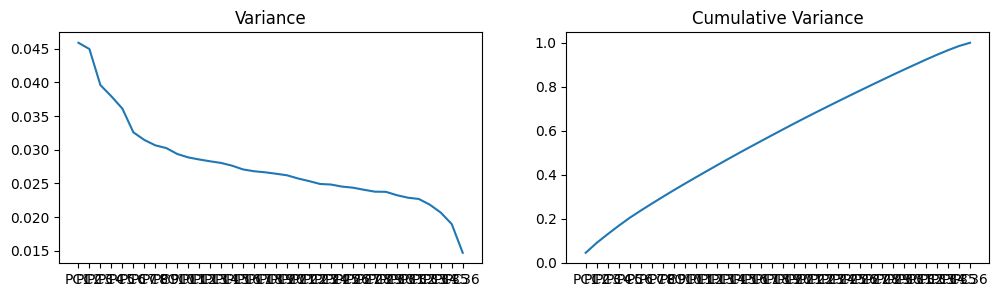

In [18]:
var_expl = pca.explained_variance_ratio_
cum_var_expl = []
var = 0
for pc in var_expl:
    var = var + pc
    cum_var_expl.append(var)
#print(cum_var_expl)
pca_var = {'Var': list(var_expl), 'CUM_Var': cum_var_expl}
pca_var = pd.DataFrame(pca_var).set_index(pca_tokens_red.columns)
print(pca_var.head())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
ax1.plot(pca_var['Var'])
ax1.set_title('Variance')
ax2.plot(pca_var['CUM_Var'])
ax2.set_title('Cumulative Variance')

In [19]:
pca = PCA()
pca.fit(pca_tokens_white)
pca_tokens_white = pca.transform(pca_tokens_white)
pca_tokens_white = pd.DataFrame(pca_tokens_white, columns=[f'PC{i}' for i in range(1, tfidf_tokens_white.shape[1]+1)])
pca_tokens_white.tail(3)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41
38601,-0.159557,-0.165817,0.139427,2.171619,0.297137,0.370838,-0.953282,-0.786208,0.698433,1.801461,...,-0.673963,-0.863057,0.524440,0.814975,0.101540,-0.426276,-0.847698,0.092502,0.606335,-0.459617
38602,-0.881611,0.255004,0.756983,1.787248,-0.588836,0.366811,1.039454,-1.178470,2.267086,1.237840,...,-1.165177,-1.072167,-0.848666,-0.025068,0.387398,0.052031,0.740875,0.931256,0.245269,-0.170525
38603,1.129978,-0.576593,-0.842000,0.113956,-0.738246,1.341327,-0.618875,-1.126316,0.997365,1.555682,...,0.428932,1.244243,-0.130292,-1.702454,0.333840,-0.195342,-0.628920,0.306872,-1.354578,-0.184820


          Var   CUM_Var
PC1  0.048549  0.048549
PC2  0.037980  0.086529
PC3  0.034787  0.121316
PC4  0.033386  0.154702
PC5  0.032380  0.187082


Text(0.5, 1.0, 'Cumulative Variance')

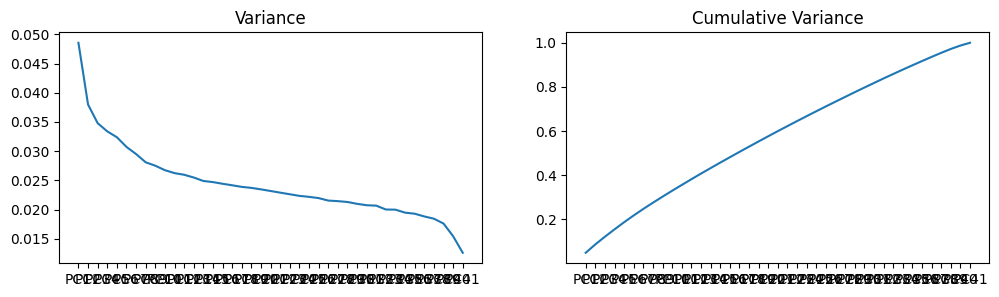

In [20]:
var_expl = pca.explained_variance_ratio_
cum_var_expl = []
var = 0
for pc in var_expl:
    var = var + pc
    cum_var_expl.append(var)
#print(cum_var_expl)
pca_var = {'Var': list(var_expl), 'CUM_Var': cum_var_expl}
pca_var = pd.DataFrame(pca_var).set_index(pca_tokens_white.columns)
print(pca_var.head())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
ax1.plot(pca_var['Var'])
ax1.set_title('Variance')
ax2.plot(pca_var['CUM_Var'])
ax2.set_title('Cumulative Variance')

In [21]:
pca = PCA()
pca.fit(pca_tokens_rose)
pca_tokens_rose = pca.transform(pca_tokens_rose)
pca_tokens_rose = pd.DataFrame(pca_tokens_rose, columns=[f'PC{i}' for i in range(1, tfidf_tokens_rose.shape[1]+1)])
pca_tokens_rose.tail(3)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29
4095,1.511404,0.217610,-0.205482,0.991114,-0.542346,-1.681628,0.696239,-0.440170,1.663860,1.298438,...,1.111663,0.305546,0.488559,0.444814,0.771119,-1.284875,1.532438,-0.875000,0.429904,0.374728
4096,1.114740,2.736385,-0.268497,-0.265072,-0.849463,0.495119,-1.290251,0.714419,0.450065,-1.148399,...,0.922742,-0.838462,0.450895,-1.431407,1.234770,2.117587,-1.682880,-1.315430,-0.409976,-0.176120
4097,0.288503,-2.421365,-0.461869,-1.116412,3.226787,-0.282789,-2.890606,1.628628,0.798324,-0.206600,...,1.030632,0.412777,1.443183,1.364073,0.484629,-1.368348,0.558438,-0.177575,0.465007,1.164226


          Var   CUM_Var
PC1  0.068072  0.068072
PC2  0.057862  0.125934
PC3  0.045970  0.171904
PC4  0.043899  0.215803
PC5  0.041050  0.256853


Text(0.5, 1.0, 'Cumulative Variance')

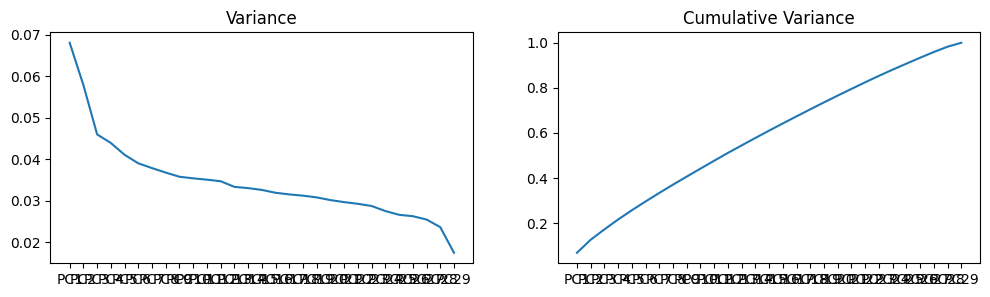

In [22]:
var_expl = pca.explained_variance_ratio_
cum_var_expl = []
var = 0
for pc in var_expl:
    var = var + pc
    cum_var_expl.append(var)
#print(cum_var_expl)
pca_var = {'Var': list(var_expl), 'CUM_Var': cum_var_expl}
pca_var = pd.DataFrame(pca_var).set_index(pca_tokens_rose.columns)
print(pca_var.head())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
ax1.plot(pca_var['Var'])
ax1.set_title('Variance')
ax2.plot(pca_var['CUM_Var'])
ax2.set_title('Cumulative Variance')

In [23]:
pca = PCA()
pca.fit(pca_tokens_spark)
pca_tokens_spark = pca.transform(pca_tokens_spark)
pca_tokens_spark = pd.DataFrame(pca_tokens_spark, columns=[f'PC{i}' for i in range(1, tfidf_tokens_spark.shape[1]+1)])
pca_tokens_spark.tail(3)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35
4295,0.689294,2.393790,-0.556914,0.093756,0.747137,-0.574211,1.475817,-0.941113,-0.461171,-0.689157,...,1.320762,-1.708605,-0.907345,-0.783840,-0.937817,1.514839,-0.000391,0.218701,-1.616426,-0.423435
4296,2.145378,-0.531802,-1.074881,-0.983587,0.559123,-2.713656,3.129488,-2.365564,-2.219015,0.088625,...,0.309084,0.299312,-0.287225,1.682361,0.339439,-0.297745,0.749991,-0.401991,0.543385,-1.178181
4297,-0.763419,-0.540626,2.438310,-0.648248,1.007013,-0.568429,-0.512041,-1.047233,2.684068,-0.635081,...,-0.637821,-0.807186,0.417007,1.165037,-0.004894,1.325458,1.754111,-0.577784,-0.276549,1.064865


          Var   CUM_Var
PC1  0.056956  0.056956
PC2  0.049380  0.106336
PC3  0.046060  0.152396
PC4  0.044727  0.197123
PC5  0.040693  0.237815


Text(0.5, 1.0, 'Cumulative Variance')

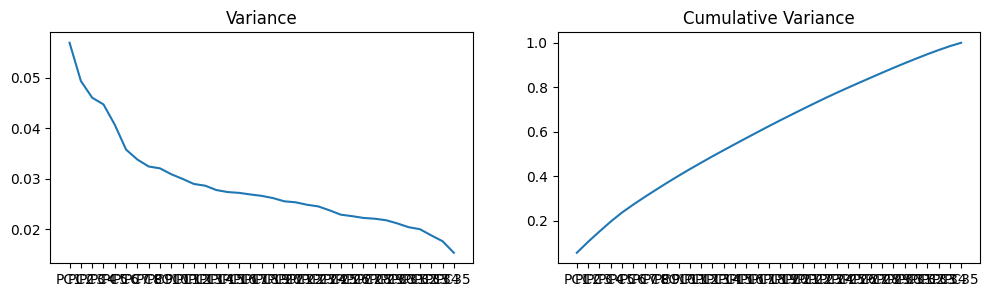

In [24]:
var_expl = pca.explained_variance_ratio_
cum_var_expl = []
var = 0
for pc in var_expl:
    var = var + pc
    cum_var_expl.append(var)
#print(cum_var_expl)
pca_var = {'Var': list(var_expl), 'CUM_Var': cum_var_expl}
pca_var = pd.DataFrame(pca_var).set_index(pca_tokens_spark.columns)
print(pca_var.head())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
ax1.plot(pca_var['Var'])
ax1.set_title('Variance')
ax2.plot(pca_var['CUM_Var'])
ax2.set_title('Cumulative Variance')

### End of method #3

## Below: Pieces of cose that can be explore, reused later

<Axes: ylabel='total'>

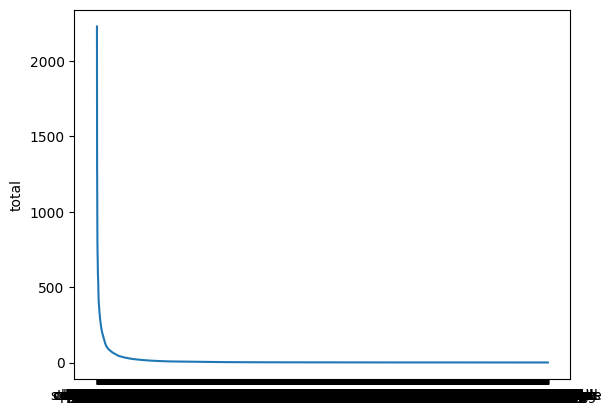

In [29]:
sns.lineplot(lda_tokens_tot.loc['total'])

In [31]:
(15/132)*19624

2230.0

In [34]:
(2.4/13.1)*2230

408.5496183206107

<Axes: ylabel='total'>

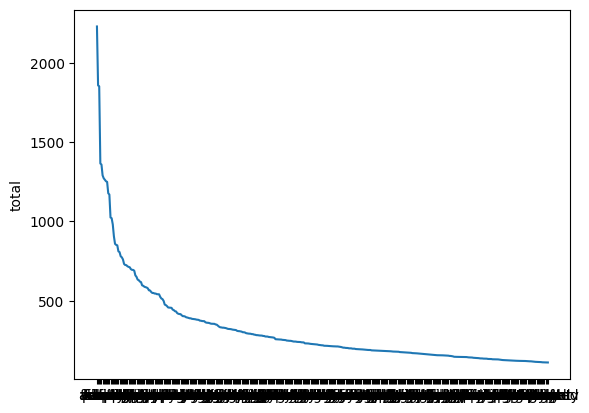

In [35]:
sns.lineplot(lda_tokens_tot.iloc[2, :400])

In [42]:
tokens400 = list(lda_tokens_tot.columns[:400])

In [46]:
tokens400

['wine',
 'fruit',
 'flavor',
 'aroma',
 'acidity',
 'finish',
 'palate',
 'tannin',
 'drink',
 'cherry',
 'ripe',
 'black',
 'note',
 'red',
 'spice',
 'berry',
 'fresh',
 'rich',
 'dry',
 'oak',
 'full',
 'plum',
 'soft',
 'apple',
 'blackberry',
 'nose',
 'sweet',
 'crisp',
 'show',
 'light',
 'well',
 'offer',
 'texture',
 'white',
 'blend',
 'citrus',
 'dark',
 'bright',
 'fruity',
 'bodied',
 'hint',
 'raspberry',
 'juicy',
 'vanilla',
 'herb',
 'cabernet',
 'green',
 'touch',
 'give',
 'pepper',
 'peach',
 'firm',
 'character',
 'year',
 'good',
 'lemon',
 'currant',
 'pear',
 'balanced',
 'feel',
 'structure',
 'chocolate',
 'wood',
 'open',
 'like',
 'smooth',
 'dried',
 'spicy',
 'fine',
 'sauvignon',
 'mineral',
 'medium',
 'pinot',
 'ready',
 'vineyard',
 'come',
 'made',
 'tannic',
 'style',
 'concentrated',
 'lead',
 'herbal',
 'orange',
 'balance',
 'also',
 'mouth',
 'lime',
 'tart',
 'creamy',
 'still',
 'merlot',
 'clean',
 'aging',
 'toast',
 'licorice',
 'age',
 'al

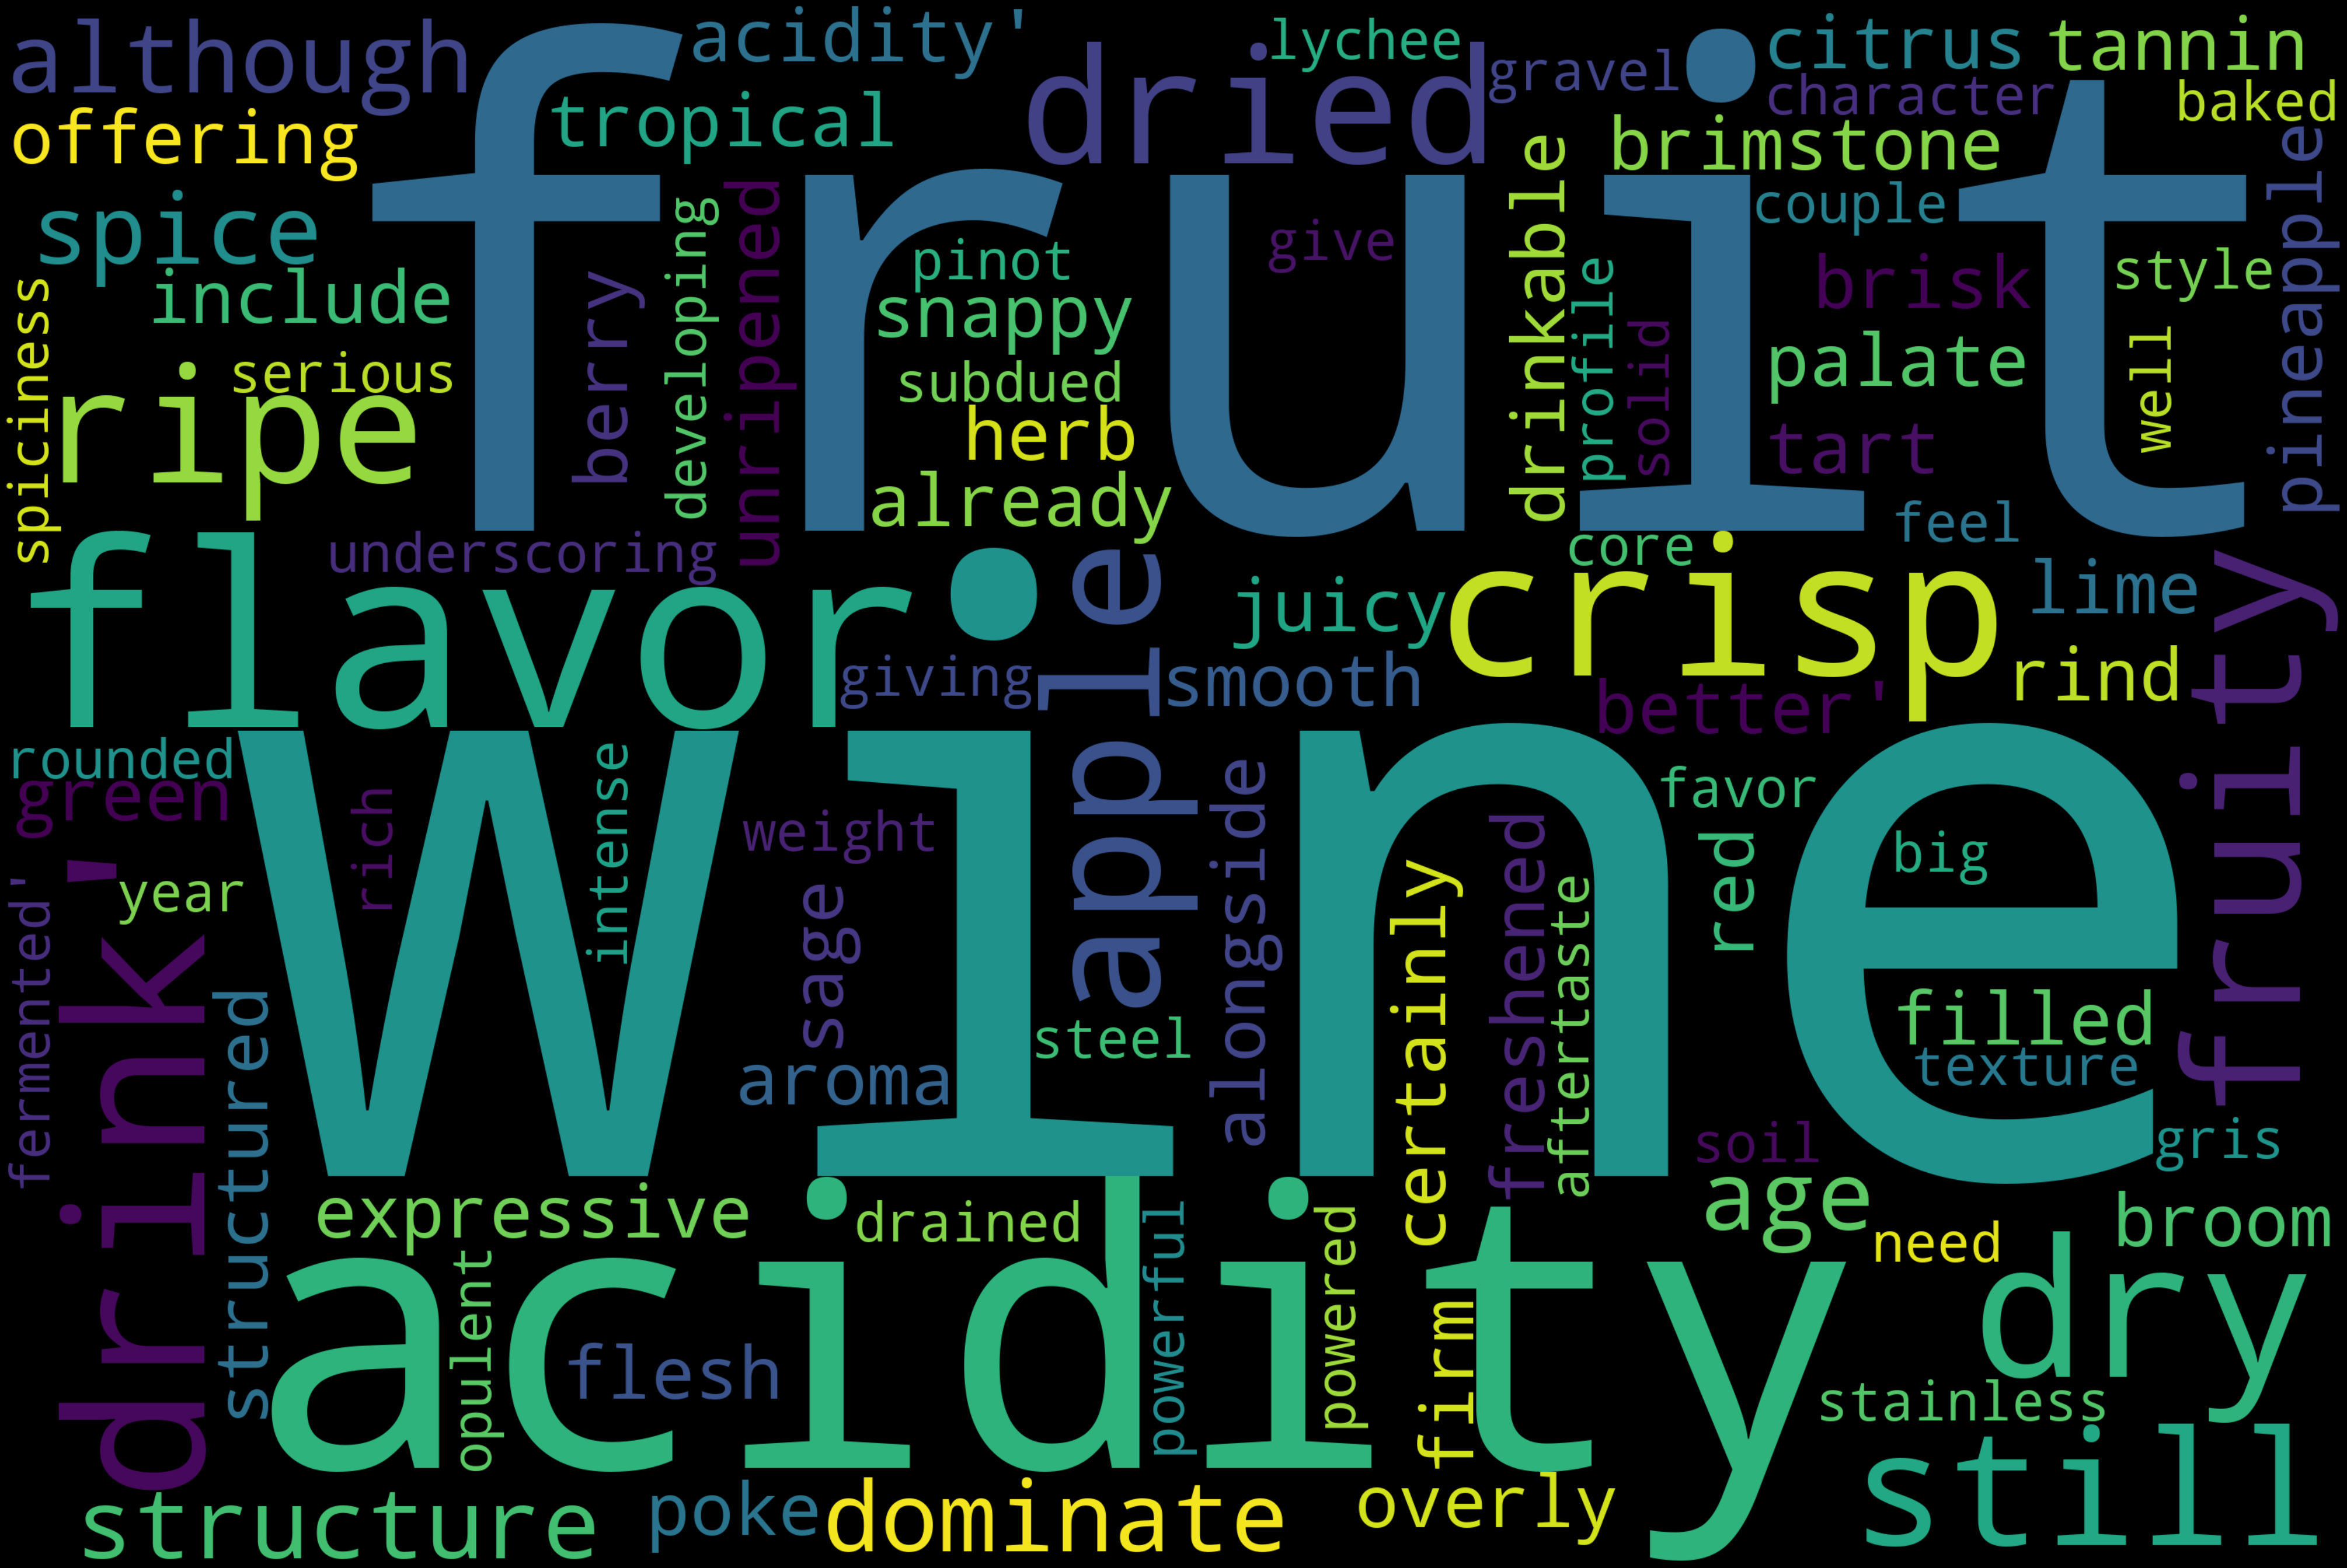

In [11]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = df.description_clean.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
wine_by_type = [df_rd, df_w, df_rs, df_s]
colors = ['rd', 'w', 'rs', 's']
for type in range(len(wine_by_type)):
    vectorizer_tfidf = TfidfVectorizer(min_df=0.1, max_df=0.9, max_features=200)
    vectorized_descr_tfidf = vectorizer_tfidf.fit_transform(wine_by_type[type]['description_clean'])
    #color = 'vectorized_descr_tfidf_'+colors[type]
    'vectorized_descr_tfidf_'+colors[type] = pd.DataFrame(color.toarray(), columns = vectorizer_tfidf.get_feature_names_out())
    print(color)

In [122]:
if X.shape[0] != len(y):
    print("WRONG!!!!!!")
else:
    print("all good")
    print(f'Tokens :   {X.shape[1]}')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
lr = LogisticRegression(multi_class='ovr',solver='lbfgs')
model = lr.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print ("Accuracy is {}".format(accuracy))

In [45]:
# Access our 13 PCs 
#W = pca.components_

# Print PCs as COLUMNS
#W = pd.DataFrame(W.T,
#                 index=token_names_spark,
#                 columns=[f'PC{i}' for i in range(1, tfidf_tokens_spark.shape[1]+1)])
#W




pcs_tokens_spark = pca.transform(X_spark)
pcs_tokens_spark = pd.DataFrame(pcs_tokens_spark, columns=[f'PC{i}' for i in range(1, tfidf_tokens_spark.shape[1]+1)])
pcs_tokens_spark

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35
0,0.404454,1.943963,0.735195,-0.152153,1.064842,-1.509245,-1.350100,1.671674,0.480713,-0.010551,...,-1.112856,-0.025889,-0.868274,1.685511,0.038271,1.893625,-0.513566,0.029558,-0.994738,-0.043994
1,1.210708,3.404868,0.267387,-1.103219,0.191986,-0.368533,0.331330,-0.932859,1.178797,-0.070237,...,0.382775,-1.134637,0.456076,0.330180,0.076674,-0.228571,-0.237407,1.062985,-0.539689,-0.664105
2,-2.261902,-0.700900,-0.246047,-0.562958,0.529393,1.443023,0.308611,2.260625,-1.689821,2.142222,...,-1.084369,0.143664,1.010798,0.780238,-0.530212,4.109962,1.547966,0.265482,-0.327414,-0.603708
3,-1.783449,-1.609931,3.132327,1.549266,-0.254678,-0.977170,0.263668,0.405701,0.030828,1.141687,...,1.079450,0.537015,-0.102490,0.828313,-0.699180,-1.419812,-0.115004,2.183431,-0.587896,-0.282998
4,-1.148688,-2.759747,0.020249,-1.149803,0.743032,0.187975,-0.807872,-1.308465,0.796975,0.193709,...,-0.047646,-0.231072,0.740380,-0.956170,-1.025249,1.405544,0.512019,-0.442825,-0.578615,-0.684731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4293,3.053070,-2.248344,-0.437444,-0.162196,1.339570,1.738237,-1.069669,0.336506,0.831540,1.058603,...,1.079258,0.932263,-0.204320,-1.651365,0.120084,0.295130,0.161124,0.380086,-0.324074,0.648783
4294,-0.920394,-0.324570,-1.516279,1.094892,-0.683783,-1.439249,-0.835533,0.404177,-0.139243,-1.014825,...,0.712288,-0.778558,1.984794,-0.875957,-0.243015,0.400330,-0.446731,-0.849890,-0.733316,0.002923
4295,0.689294,2.393790,-0.556914,0.093756,0.747137,-0.574211,1.475817,-0.941113,-0.461171,-0.689157,...,1.320762,-1.708605,-0.907345,-0.783840,-0.937817,1.514839,-0.000391,0.218701,-1.616426,-0.423435
4296,2.145378,-0.531802,-1.074881,-0.983587,0.559123,-2.713656,3.129488,-2.365564,-2.219015,0.088625,...,0.309084,0.299312,-0.287225,1.682361,0.339439,-0.297745,0.749991,-0.401991,0.543385,-1.178181
